In [2]:
# importing the libraries

import torch, torchvision, os, PIL, pdb
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def show(tensor,num_images=25,wandbactive=0,name=""): # "wandb" means weights and biases
  data = tensor.detach().cpu()
  grid = make_grid(data[:num_images],nrow=5).permute(1,2,0)

  # optional. By doing this content of visual grid to weight and biases website
  if (wandbactive==1 and wandbact==1):
    wandbactive.log({name:wandbactive.Image(grid.numpy().clip(0,1))})
  plt.imshow(grid.clip(0,1)) # cliiping the value of pixel 0 to 1 for kind of normalization
  plt.show()

### hyperparameters
n_epochs = 10000
batch_size = 128
lr = 1e-4
z_dim = 200 # we want higher dimensionality in our latent space
device = "cuda" if torch.cuda.is_available() else "cpu"

cur_step = 0
crit_cycles = 5 # In previous basic GAN cycle was of one, first one cycle of discriniator then one cycle of generator, here we do 5 cycles of discriminator & 1 cycle of generator
gen_losses = [] # to accumulate loss values of generator
crit_losses = [] # to accumulate loss values of discriminator or so called "critic"
show_step = 35 # after how many steps we show the training steps
save_step =  35 # after how many steps we save the parameters and the value of generator and critic

wandbact = 1 # yes, we want to track the stats through weught and biases , optional

This will install the Weight & Biases module.

In [3]:
### optional
!pip install wandb -qqq
import wandb
wandb.login(key="ad5469001eccfe7de121f06517e057df1bc980c4")

wandb: Currently logged in as: utkrisht14. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
%%capture
experiment_name = wandb.util.generate_id()

myrun = wandb.init(
    project = "wgan",
    group = experiment_name,
     config = {
        "optimizer":"adam",
        "model": "wgan gp",
        "epoch": "1000",
        "batch_size": 128
    }
)

config = wandb.config

print(experiment_name)

In [5]:
print(experiment_name)

7hw0l4lz


Now we can see our experiment on weight and biases website.

Next we will construct the generator model.

In [6]:
# generator model
class Generator(nn.Module):
  def __init__(self,z_dim=64,d_dim=16):
    super(Generator,self).__init__()
    self.z_dim = z_dim

    self.gen = nn.Sequential(
        ## ConvTranspose2d : in_channels, out_channels, kernel_size, stride=1, padding=0
        ## Calculating the new width and height : (n-1) x stride - 2 x padding + ks. These operations are in sequence not in BODMAS form.
        ## n = width or height
        ## ks = kernel size
        ## we begin with a 1*1 image with z_dim number of channels i.e. 200
        nn.ConvTranspose2d(in_channels = z_dim,out_channels = d_dim*32, kernel_size= 4,stride=2,padding=1), # 4*4 (ch:200-->512) 16*32 = 512
        nn.BatchNorm2d(d_dim*32), # Normalize the output of previous layer
        nn.ReLU(inplace=True), # introducing non-linearity

        nn.ConvTranspose2d(in_channels=d_dim*32, out_channels=d_dim*16, kernel_size=4, stride=2,padding=1), ## 8*8 (ch:512-->256)
        nn.BatchNorm2d(d_dim*16), # Normalize the output of previous layer
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(in_channels=d_dim*16, out_channels=d_dim*8, kernel_size=4, stride=2, padding=1), # 16*16 (ch:256-->128)
        # (n-1)*stride- 2*padding + ks = ((8-1)*2)-(2*1) + 4 = 16
        nn.BatchNorm2d(d_dim*8),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(in_channels=d_dim*8, out_channels=d_dim*4, kernel_size=4, stride=2, padding=1), # 32*32 (ch:128-->64)
        nn.BatchNorm2d(d_dim*4),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(in_channels=d_dim*4, out_channels=d_dim*2, kernel_size=4, stride=2, padding=1), # 64*64 (ch:64-->32)
        nn.BatchNorm2d(d_dim*2),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(in_channels=d_dim*2, out_channels=3, kernel_size=4, stride=2, padding=1), # 64*64 (ch:32-->3) Output- 3 channels
        nn.Tanh() ## produce a result in range of -1 to 1. Suitable for such kind of GAN
    )

  # Define the forward function
  def forward(self,noise):
    x = noise.view(len(noise),self.z_dim,1,1) # 128 x 200 x 1 x 1  (batch_size x dimensionality_of_latent_space x width x height).
                          # So we will reconfigure noise vector
    return self.gen(x)

# Function to generate noise
def gen_noise(num,z_dim,device=device):
  return torch.randn(num,z_dim,device=device) # 128 * 200


* z_dim = dimensionality of the latent space
* d_dim = dimensionality for the output channels of convolution layer
* ConvTranspose2d : in_channels, out_channels, kernel_size, stride=1,  padding=0
* Calculating the new width and height : (n-1) x stride - 2 x padding + ks
* n = width or height
* ks = kernel size  


The operation of above is shown below:
<br/> &emsp; Formula is: <b> ((n-1)*stride) - (2 x padding_size) + (kernel_size)
* 1st layer: </b> when n=4 => ((4-1)*2) - (2 x 1) + (4)) => ((3x2) - (2) + (4)) => (6 - 2 + 4) => (10-2) => 8   
* **2nd layer**: now n=8 => ((8-1)*2) - (2 x 1) + (4)) => ((7x2) - (2) + (4)) => (14 - 2 + 4) => (18-2) => 16
* **3rd layer**: now n=16 => ((16-1)*2) - (2 x 1) + (4)) => ((15x2) - (2) + (4)) => (30 - 2 + 4) => (34-2) => 32
* **4th layer**: now n=32 => ((32-1)*2) - (2 x 1) + (4)) => ((31x2) - (2) + (4)) => (62 - 2 + 4) => (66-2) => 64

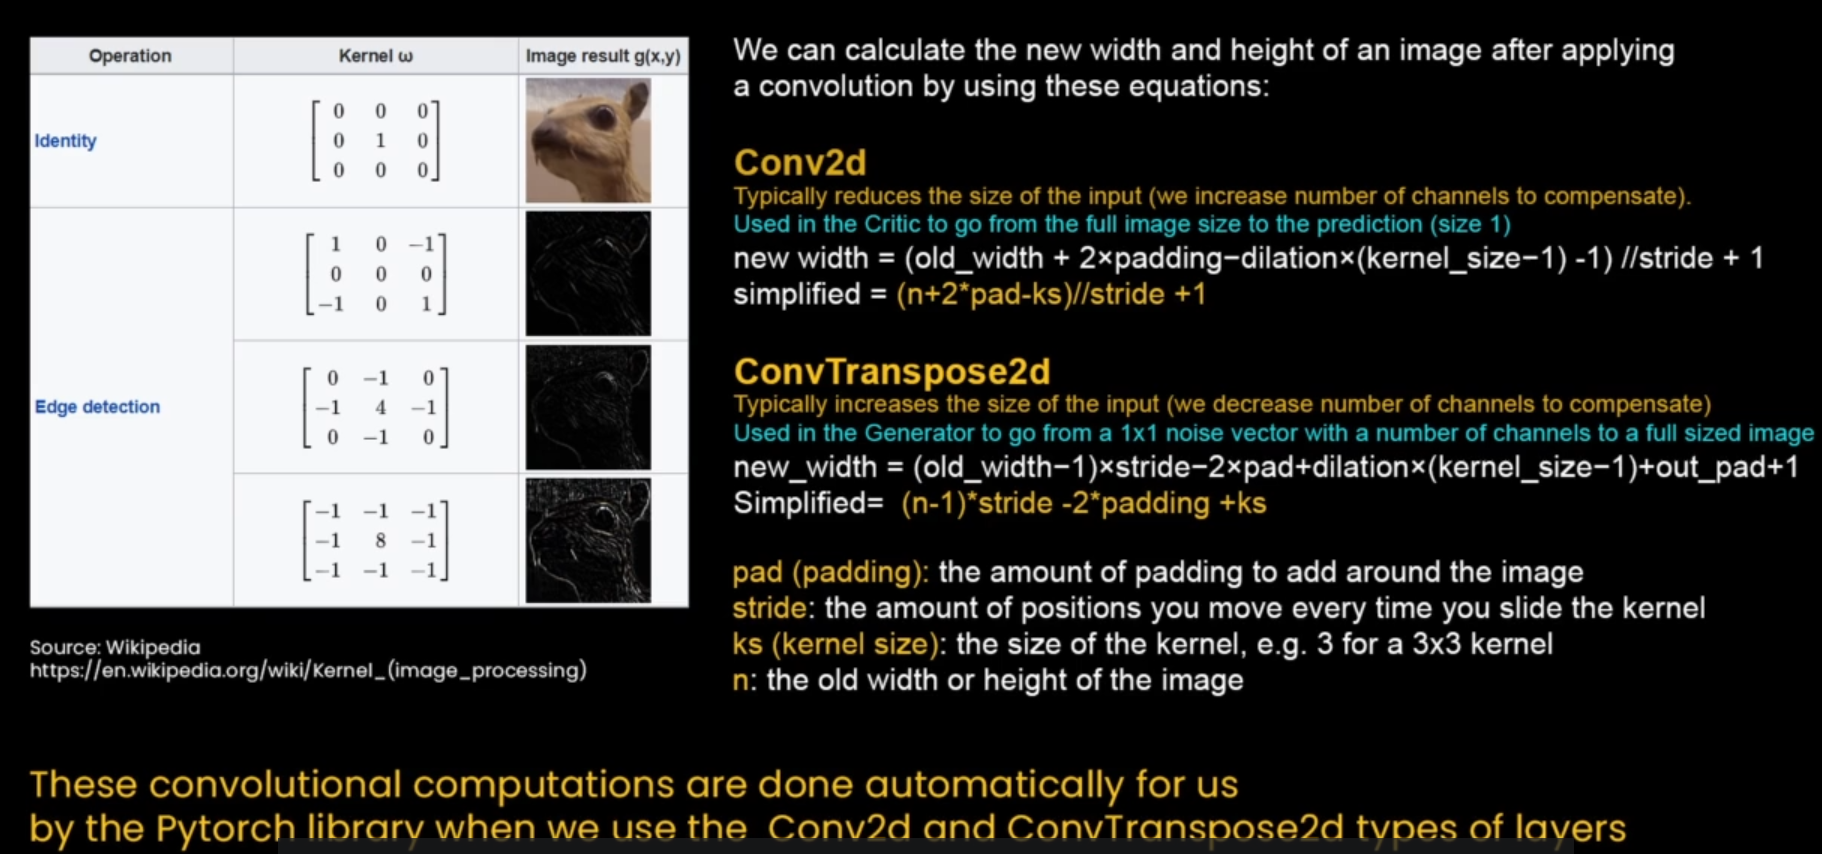

Now we will code the critic class.

In [7]:
## critic model
# con2d: in_channels,out_channels,kernel_size, stride=1, padding=0
# New width and height : (n+2*pad-ks)//stride+1

class Critic(nn.Module):
  def __init__(self,d_dim=16):
    super(Critic,self).__init__()
    self.crit = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=d_dim,kernel_size=4,stride=2,padding=1), # RGB (3) input channels
                                                                                      # (((n+ (2*pad)-(ks))//(stride)) +1 = (((128+(2*1)-(4)//2))+1 = 64*64 (ch: 3-->16)
        nn.InstanceNorm2d(d_dim), # normalizing by instance. In case of critics normalizing by instance works best.
        nn.LeakyReLU(negative_slope=0.2,inplace=True), # To avoid "dying neuron" problems

        nn.Conv2d(in_channels=d_dim,out_channels=d_dim*2,kernel_size=4,stride=2,padding=1), ## 32*32 (channels: 16-->32)
        nn.InstanceNorm2d(d_dim*2),
        nn.LeakyReLU(negative_slope=0.2),

        nn.Conv2d(d_dim*2,d_dim*4,kernel_size=4,stride=2,padding=1), ## 16*16 (ch: 32,64)
        nn.InstanceNorm2d(d_dim*4),
        nn.LeakyReLU(negative_slope=0.2),

        nn.Conv2d(d_dim*4,d_dim*8,kernel_size=4,stride=2,padding=1), ## 8x8 (ch:64,128)
        nn.InstanceNorm2d(d_dim*8),
        nn.LeakyReLU(negative_slope=0.2),

        nn.Conv2d(d_dim*8,d_dim*16,kernel_size=4,stride=2,padding=1), ## 4x4 (ch:128-->256)
        nn.InstanceNorm2d(d_dim*16),
        nn.LeakyReLU(negative_slope=0.2),

        nn.Conv2d(d_dim*16,out_channels=1,kernel_size=4,stride=1,padding=0), # (((4+(2*0)-(4)//1))+1, (channel:256*1)

      )

  def forward(self,image):
    # image: 128 x 3 x 128 x 128 --> batch_size x num_channels x width x height
    crit_pred = self.crit(image) # 128 x 1 x 1 x 1
    return crit_pred.view(len(crit_pred),-1)  ## 128 x 1  --> batch_size x real_or_fake



The calculation for each step of image size is shown below:

Formula is:  (((num_pixels)+(2*padding)-(kernel_size)) // (stride)) + 1
* 1st Conv2d:  (((128)+(2*1)-(4)) // (2)) + 1 --> (126 // 2) + 1 --> 63 + 1 --> 64
* 2nd Conv2d:  (((64)+(2*1)-(4)) // (2)) + 1 --> (62 // 2) + 1 --> 31 + 1 --> 32
* 3rd Conv2d: (((32)+(2*1)-(4)) // (2)) + 1 --> (30 // 2) + 1 --> 15 + 1 --> 16
* 4th Conv2d: (((16)+(2*1)-(4)) // (2)) + 1 --> (14 // 2) + 1 --> 7 + 1 --> 8
* 5th Conv2d: (((8)+(2*1)-(4)) // (2)) + 1 --> (6 // 2) + 1 --> 3 + 1 --> 4
* 6th Conv2d: (((4)+(2*0)-(4)) // (2)) + 1 --> (0 // 2) + 1 --> 0 + 1 --> 1


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
download_path = "/content/drive/MyDrive/Colab Notebooks/img_align_celeba.zip"
path = r"/content/celeba"

import zipfile
with zipfile.ZipFile(download_path,"r") as ziphandler:
    ziphandler.extractall(path)

In [10]:
# Dataset, DataLoader, declare, gen, crit test_dataset

class Dataset(Dataset):
  def __init__(self,path,size=128,lim=10000): # 128 size would be enough to extract the features of face, 64 and 32 would be very low
    self.sizes = [size,size] # image width and image height will be used during training
    items, labels = [], [] # going to hold the path of images and

    for data in os.listdir(path)[:lim]: # first 10,000 files in the folder
      # path: "./celeba/img_align_celeba"
      # data: "114568.jpg"
      item = os.path.join(path,data)
      items.append(item)
      labels.append(data)
    self.items = items
    self.labels = labels

  def __len__(self):
    return len(self.items)

  def __getitem__(self,idx):
    data = PIL.Image.open(self.items[idx]).convert("RGB") # (178,218)
    data = np.asarray(torchvision.transforms.Resize(self.sizes)(data))  # 128*128*3 --> width, height, size
                                                                  # But PyTorch is expecting to be channels,width,height. So, converting
    data = np.transpose(data,(2,0,1)).astype(np.float32,copy=False) # 3*128*128 --> In torch tensor
    data = torch.from_numpy(data).div(255) # from 0 to 1 --> from 0 to 1
    return data, self.labels[idx]

## Dataset
data_path = "/content/celeba/img_align_celeba"
ds = Dataset(data_path,size=128,lim=10000)

<div style="background-color: lightblue; width: 1100px; height: 130px; padding: 10px;">
    <font color="#8B8000" style="font-size:18px"> Use of def __getitem__() in Python class </font> 
    
* The def __getitem__(self, index) method in a Python class is used to retrieve an item from the class by its index. <br/>
* The index parameter is the index of the item to retrieve. The method should return the item at the specified index.

For example, the following code defines a class called MyClass with a __getitem__() method:

</div>

```Python

class MyClass:
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return self.data[index]


```

The MyClass class has a __getitem__() method that takes a single parameter, index. The index parameter is the index of the item to retrieve from the class. The method returns the item at the specified index.

For example, the following code creates an instance of the MyClass class and retrieves the item at index 0:


```Python
my_class = MyClass([1, 2, 3, 4])
item = my_class[0]

print(item)
```

The output of the code is:

1

The output shows that the item at index 0 is 1.

The __getitem__() method is a very useful method to have in a Python class. It allows you to retrieve items from the class by their index. This can be useful for a variety of tasks, such as accessing elements of a list or dictionary.

<br/>

Now declare the DataLoader.

In [11]:
dataloader = DataLoader(ds,batch_size=batch_size,shuffle=True)

Now define the models and optimizers.

In [12]:
## Models
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

## Optimizers
gen_opt = torch.optim.Adam(gen.parameters(),lr=lr,betas=(0.5,0.9)) # setting some parameters to work well with this type of architecture
crit_opt = torch.optim.Adam(crit.parameters(),lr=lr,betas=(0.5,0.9))

In [13]:
if (wandb==1):
  wandb.watch(gen,log_freq=100) # let weight & biases monitor generator & critic for a period of 100  & capture the statistics
  wandb.watch(crit,log_freq=100)

Now let's check whether our DataLoader is working or not.

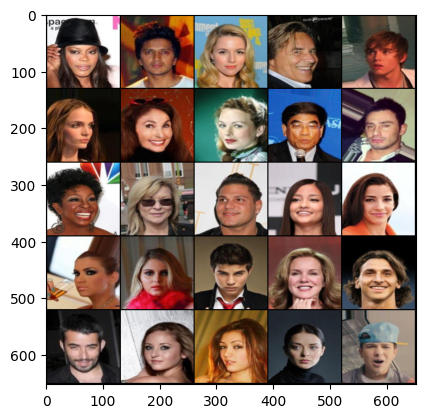

In [14]:
x,y = next(iter(dataloader))
show(x)

The above images are the real images of the celeba dataset. These images would be later used by "Critic Network".

Next we will code the gradient penalty.

<b><u>Note:</u></b> Let's see about a following function. <br/>
&emsp; torch.autograd.grad:
```Python
torch.autograd.grad(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False, only_inputs=True,
 allow_unused=False, is_grads_batched=False
```

Computes and returns the sum of gradients of outputs with respect to the inputs.

`grad_outputs` should be a sequence of length matching `output` containing the “vector” in vector-Jacobian product, usually the pre-computed gradients w.r.t. each of the outputs. If an output doesn’t require_grad, then the gradient can be `None`).

Fot more about `torch.autograd.grad()`  <a href="https://pytorch.org/docs/stable/generated/torch.autograd.grad.html"> click here for documentation </a>



**torch.autograd.grad() in full details:**

In PyTorch, `torch.autograd.grad()` is a function that computes the gradients of a given tensor with respect to specified variables. It is a part of the automatic differentiation (autograd) system in PyTorch, which allows computing gradients of scalar-valued functions with respect to tensors.

The function signature of `torch.autograd.grad()` is as follows:

```python
torch.autograd.grad(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False, only_inputs=True, allow_unused=False)
```

Here's what each parameter means:

- `outputs`: A tensor or a sequence of tensors representing the outputs of the computational graph for which gradients are to be computed.
- `inputs`: A tensor or a sequence of tensors representing the inputs with respect to which the gradients are calculated. These are the variables for which we want to compute the gradients of `outputs`.
- `grad_outputs` (optional): A tensor or a sequence of tensors representing the initial gradients for each output tensor. If `None`, the gradients are assumed to be ones (i.e., all ones).
- `retain_graph` (optional): If `True`, the computation graph is retained for multiple backward passes. If `False`, the graph is freed after the backward pass. Default is `None`, which means the graph behavior is determined automatically.
- `create_graph` (optional): If `True`, the backward pass will create a new computation graph, allowing for second-order derivatives (i.e., gradients of gradients). Default is `False`.
- `only_inputs` (optional): If `True`, only the gradients of `inputs` will be returned. If `False`, the gradients of all intermediate tensors in the computation graph will be returned. Default is `True`.
- `allow_unused` (optional): If `True`, it allows specifying inputs that are not used in the computation graph, and their gradients will be set to `None`. Default is `False`.

The `torch.autograd.grad()` function is particularly useful when you want to compute gradients manually for custom loss functions, or when you want to perform tasks like gradient clipping, second-order optimization methods, or adversarial attacks.

Here's a simple example of how to use `torch.autograd.grad()` to compute gradients:

```python
import torch

# Define a simple function: y = 3x^2 + 2x + 1
x = torch.tensor([2.0], requires_grad=True)
y = 3 * x**2 + 2 * x + 1

# Compute gradients of y with respect to x
grads = torch.autograd.grad(y, x)

print(grads)  # Output: (tensor([14.]),)
```

In this example, we have a simple function `y = 3x^2 + 2x + 1`. We compute the gradients of `y` with respect to `x` using `torch.autograd.grad()`, and the result is `tensor([14.])`, which is the gradient of `y` with respect to `x` evaluated at `x=2`.

<div style="background-color: lightblue; width: 1100px; height: 430px; padding: 10px;">
    <font color="#8B8000" style="font-size:18px"> Use of `torch.autograd.grad()` in GANs: </font>
  
  In Generative Adversarial Networks (GANs), the `torch.autograd.grad()` function is not typically used directly in the training process itself. However, it can be useful in certain scenarios related to GANs, especially when implementing advanced techniques or custom loss functions. Here are a few cases where `torch.autograd.grad()` might be used in GANs:

1. Gradient Penalty in WGAN-GP:
   - In Wasserstein GANs with Gradient Penalty (WGAN-GP), a gradient penalty term is added to the critic's loss to enforce the Lipschitz constraint. The gradient penalty is computed using `torch.autograd.grad()` to encourage smoothness of the critic function.
   
2. Adversarial Attacks:
   - In some research on adversarial attacks and defenses, `torch.autograd.grad()` can be used to compute the gradients of the discriminator's output with respect to the input data (e.g., images). These gradients can then be used to generate adversarial examples for fooling the discriminator.

3. Custom Loss Functions:
   - In custom loss functions used in GANs, you might need to compute gradients with respect to specific model parameters or intermediate outputs. `torch.autograd.grad()` can be used to calculate these gradients efficiently.

4. Second-Order Optimization:
   - If you are using second-order optimization algorithms (e.g., L-BFGS) in GANs, setting `create_graph=True` in `torch.autograd.grad()` can be helpful to enable computing second-order derivatives.

It's important to note that the `torch.autograd.grad()` function is part of the PyTorch automatic differentiation (autograd) system, which automatically computes gradients during the backward pass of the optimization process. The main training loop in GANs typically relies on the automatic differentiation mechanism, and you don't need to manually call `torch.autograd.grad()` for gradient computation during the standard training process.

Most GAN implementations utilize pre-defined loss functions and optimizers provided by PyTorch, which internally handle the computation of gradients. However, in advanced GAN variations or custom implementations, you may encounter situations where `torch.autograd.grad()` becomes relevant for specific tasks like those mentioned above.

</font>



**Let's delve into the first point, which is the use of the `torch.autograd.grad()` function in the context of the Wasserstein GAN with Gradient Penalty (WGAN-GP).**

1. Gradient Penalty in WGAN-GP:
   - WGAN-GP is a variant of the original Wasserstein GAN (WGAN) that introduces a gradient penalty term to the critic's loss function. The gradient penalty is used to enforce the Lipschitz constraint on the discriminator (critic) to stabilize the training process and improve the quality of generated samples.

   - In WGAN-GP, the critic's loss function is defined as the Wasserstein distance between the distribution of real data and the distribution of generated data. The gradient penalty is then added to the loss to ensure that the critic's gradient norm stays close to 1.

   - The gradient penalty term penalizes the discriminator when its gradients with respect to the input data (interpolated samples between real and generated data) deviate from the norm of 1. The penalty encourages the gradients to be close to 1 to satisfy the Lipschitz constraint.

   - The gradient penalty term is computed using `torch.autograd.grad()`. Specifically, interpolated samples are generated by sampling points along straight lines between pairs of real and generated data. The gradients of the critic's output with respect to these interpolated samples are then calculated using `torch.autograd.grad()`.

   - The penalty term is computed as the square of the difference between the magnitude of the gradients and 1. This term is added to the critic's loss, and the total loss is used for updating the critic's parameters during backpropagation.

   - By adding the gradient penalty term, WGAN-GP encourages the critic to be Lipschitz continuous, which can lead to more stable training and better convergence. The gradient penalty acts as a regularization term, preventing the discriminator from becoming too powerful and potentially causing training issues.

Here's a simplified version of the WGAN-GP loss function (without other regularization terms) to illustrate the gradient penalty:

```python
import torch
import torch.nn as nn

# Define the critic (discriminator) model
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc = nn.Linear(784, 1)

    def forward(self, x):
        return self.fc(x)

# Initialize the critic model
critic = Critic()

# Generate interpolated samples between real and generated data
alpha = torch.rand(batch_size, 1, 1, 1).to(device)
interpolated_data = alpha * real_data + (1 - alpha) * generated_data
interpolated_data.requires_grad = True

# Compute the critic's output for the interpolated samples
critic_output = critic(interpolated_data)

# Compute gradients of the critic's output with respect to interpolated samples
gradients = torch.autograd.grad(outputs=critic_output, inputs=interpolated_data,
                                grad_outputs=torch.ones(critic_output.size()).to(device),
                                create_graph=True, retain_graph=True)[0]

# Compute the gradient penalty term
gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

# Compute the critic's Wasserstein loss with the gradient penalty
critic_loss = -critic_real.mean() + critic_fake.mean() + lambda_gp * gradient_penalty

# Backpropagate and update the critic's parameters
critic.zero_grad()
critic_loss.backward()
critic_optimizer.step()
```

In this simplified example, `real_data` represents real samples, `generated_data` represents generated samples from the generator, and `critic_real` and `critic_fake` are the critic's outputs for real and generated data, respectively. The `lambda_gp` parameter controls the strength of the gradient penalty. The `critic_loss` includes the Wasserstein loss and the gradient penalty term, and the critic's parameters are updated during backpropagation.

Note: The complete implementation of WGAN-GP may include additional components, such as the generator's loss, gradient clipping, and optimization steps. The example above focuses only on the gradient penalty part to illustrate its usage with `torch.autograd.grad()`.

<hr/>
Now let's go back to our original program.
<br/> Check the parameters for function once again. <br/>
&emsp;

```python
torch.autograd.grad(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False, only_inputs=True, allow_unused=False)
```

In [15]:
3*128*128

49152

In [16]:
### gradient penalty calculation

def get_gp(real,fake,crit,alpha,gamma=10): # alpha parameters is going to be set of random numbers that we are going to use
  mix_images = real * alpha + fake * (1-alpha) # 128 x 3 x 128 x 128 --> this is linear interpolation
  mix_scores = crit(mix_images) # we pass them though the critic and we obtain all the predictions of critic, 128 x 1

  gradient = torch.autograd.grad( # compute & return sum of graidents of output with respect to inputs
      inputs = mix_images, # would be a sequence of tensor,  Inputs w.r.t. which the gradient will be returned
      outputs = mix_scores, # would be a sequence of tensor, outputs of the differentiated function.
      grad_outputs = torch.ones_like(mix_scores),
      retain_graph = True,
      create_graph = True,
  )[0] # This function will give us result and we have to select the 1st part of the result.
        #  result  128 x 3 x 128 x 128 --> result of final[0] selection

  gradient = gradient.view(len(gradient),-1) # 128 x 49152    # 3*128*128 = 49152. len(gradient) would be 128

  # Now what regularization terms to penalize if the gradients are too large
  gradient_norm = gradient.norm(2,dim=1) # "2" means "L2" norm here. 128 x 49152, here dim=0 is 128 and dim=1 is 49152
  gp = gamma * ((gradient_norm-1)**2).mean()

  return gp

Next we will code for saving and loading checkpoints.

In [17]:
## Save and load checkpoints
root_path = "./celeba/"

def save_checkpoint(name):
  torch.save({
      "epoch":epoch,
      "model_state_dict": gen.state_dict(),
      "optimizer_state_dict":gen_opt.state_dict()
  }, f"{root_path}G-{name}.pkl")

  torch.save({
      "epoch":epoch,
      "model_state_dict": crit.state_dict(),
      "optimizer_state_dict":crit_opt.state_dict()
  }, f"{root_path}C-{name}.pkl")

  print("Saved checkpoint")

# Now for the load

def load_checkpoint(name):
  checkpoint = torch.load(f"{root_path}G-{name}.pkl")
  gen.load_state_dict(checkpoint["model_state_dict"])
  gen_opt.load_state_dict(checkpoint["optimizer_state_dict"])

  checkpoint = torch.load(f"{root_path}C-{name}.pkl")
  crit.load_state_dict(checkpoint["model_state_dict"])
  crit_opt.load_state_dict(checkpoint["optimizer_state_dict"])

  print("Loaded checkpoint.")

Let's check whether our code works succesfully or not.

In [18]:
epoch = 1
save_checkpoint("test")

Saved checkpoint


So, it worked. We have two files `c-test.pkl` and `G-test.pkl` in the saving test. No let's load the checkpoint.

In [19]:
load_checkpoint("test")

Loaded checkpoint.


Now we will do the critic training.

In [ ]:
## Training loops
for epoch in range(n_epochs):
  for real,_ in tqdm(dataloader):
    cur_bs = len(real) # 128

    # Critic
    mean_crit_loss = 0
    for _ in range(crit_cycles):
      crit_opt.zero_grad()

      noise = gen_noise(cur_bs,z_dim) # Creating a noise vector
      fake = gen(noise)
      crit_fake_pred  = crit(fake.detach())
      crit_real_pred = crit(real)

      # Now calculate the gradient penatly
      alpha = torch.randn(len(real),1,1,1,device=device,requires_grad=True) # 128 x 1 x 1 x 1
      gp = get_gp(real,fake.detach(),crit,alpha)

      crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp # adding the regularization term gradien penalty to loss

      mean_crit_loss += crit_loss.item() / crit_cycles

      crit_loss.backward(retain_graph=True)
      crit_opt.step()
    crit_losses  += [mean_crit_loss]


  ### Generator
  gen_opt.zero_grad()
  noise = gen_noise(cur_bs,z_dim)
  fake = gen(noise)
  crit_fake_pred = crit(fake)

  gen_loss = - crit_fake_pred.mean() # negative of the predictions of the critic
  gen_loss.backward()
  gen_opt.step()

  gen_losses += [gen_loss.item()]


  ### Statistics
  if (wandbact==1):
    wandb.log({"Epoch":epoch, "Step":cur_step, "critic_loss":mean_crit_loss, "Gen loss":gen_loss})

  if cur_step % save_step == 0 and cur_step > 0:
    print("Saving checkpoint: ",cur_step,save_step)
    save_checkpoint("latest")

  if (cur_step % show_step == 0 and cur_step>0):
    show(fake,wandbactive=1, name="fake")
    show(real,wandbactive=1, name="real")

    gen_mean = sum(gen_losses[-show_step:]) / show_step
    crit_mean = sum(crit_losses[-show_step:]) / show_step
    print(f"Epoch: {epoch}: Step: {cur_step} Generator Loss: {gen_mean}, Critic Loss:{crit_mean}")

    plt.plot(
        range(len(gen_losses)),
        torch.Tensor(gen_losses),
        label="Generator Loss"
    )

    plt.plot(
        range(gen_losses),
        torch.Tensor(crit_losses),
        label = "Critic Loss"
    )

    plt.ylim(-150,150)
    plt.legend()
    plt.show()

  cur_step +=1

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [1]:
# number of steps per epoch
# 10000 / 128 = 78.125
# 50000 / 128 = 390.625

Now we will generate new faces after training.

In [2]:
### Generate new faces
noise = gen_noise(batch_size,z_dim)
fake = gen(noise)
show(fake)

NameError: ignored

In [ ]:
plt.imshow(fake[16].detach().cpu().permute(1,2,0).squeeze().clip(0,1))

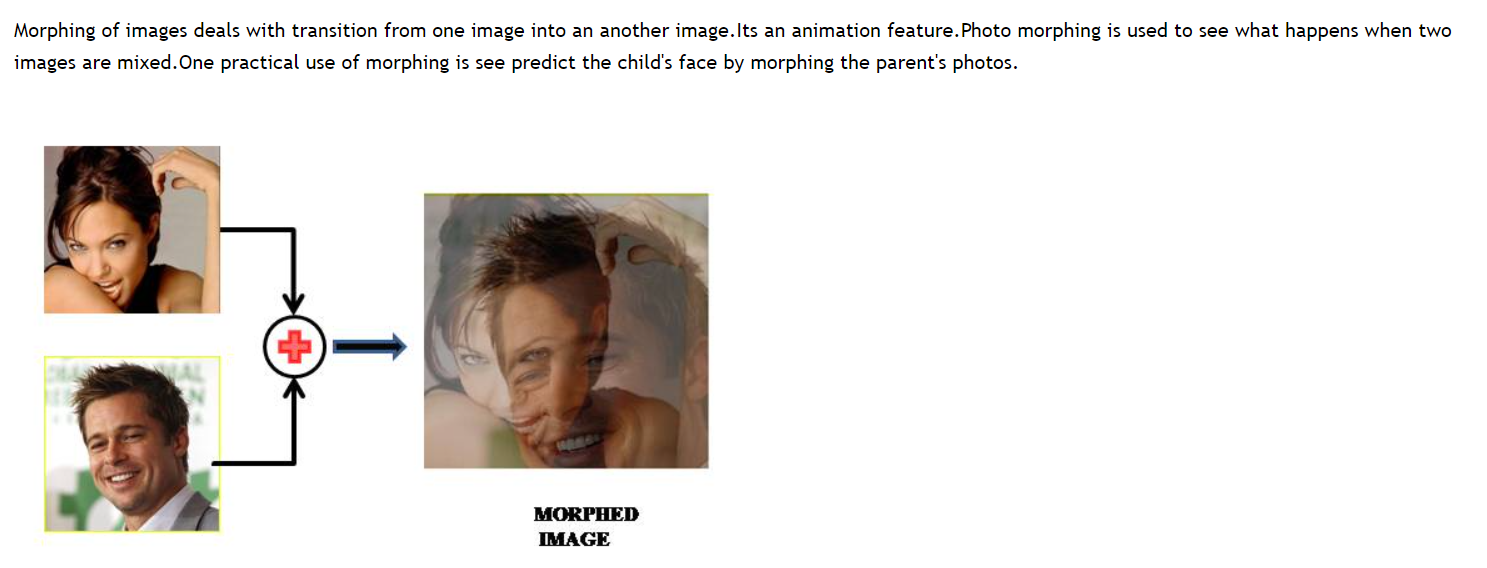

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

# MORPHING, interpolation between points in latent space
gen_set=[] # we are going to accumulate different set of images as we do interpolation
z_shape=[1,200,1,1]
rows=4 # 4 rows of image that we want to do morphing
steps=17 # morphing has 17 steps. Fro, one lateent space to another latent space. There would be 17 steps between.

for i in range(rows):
  z1,z2 = torch.randn(z_shape), torch.randn(z_shape)   # will give us couple of random point in latent space
  for alpha in np.linspace(0,1,steps):
    z=alpha*z1 + (1-alpha)*z2 # we got new point in latent space
    res=gen(z.cuda())[0] # we basically select the 1st result to get the image
    gen_set.append(res) # add it to the gen_set

fig = plt.figure(figsize=(25,11))
grid=ImageGrid(fig, 111, nrows_ncols=(rows,steps), axes_pad=0.1)  # subplot of 1 row & 1 column

for ax , img in zip (grid, gen_set):
  ax.axis('off')
  res=img.cpu().detach().permute(1,2,0)
  res=res-res.min()                       # min max normalization for getting rid of minus values.
  res=res/(res.max()-res.min())
  ax.imshow(res.clip(0,1.0))

plt.show()